In [1]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import random
from hmmlearn import hmm
from hmmlearn.base import ConvergenceMonitor
import plotly.express as px

In [2]:
df = pd.read_excel('dl_df_deposit.xlsx')
indicator_data = df.set_index("INDICATOR")
indicator_data = indicator_data.iloc[:, :-1] #на последнем ряде сделаем предикт
time_series_data = indicator_data.values 
print("Количество временных рядов:", time_series_data.shape[0])  
print("Длина каждого временного ряда:", time_series_data.shape[1]) 

# Нормализуем данные
time_series_data = TimeSeriesScalerMeanVariance().fit_transform(time_series_data)

Количество временных рядов: 35
Длина каждого временного ряда: 197


### С помощью метода локтя определяем оптимальное колво кластеров

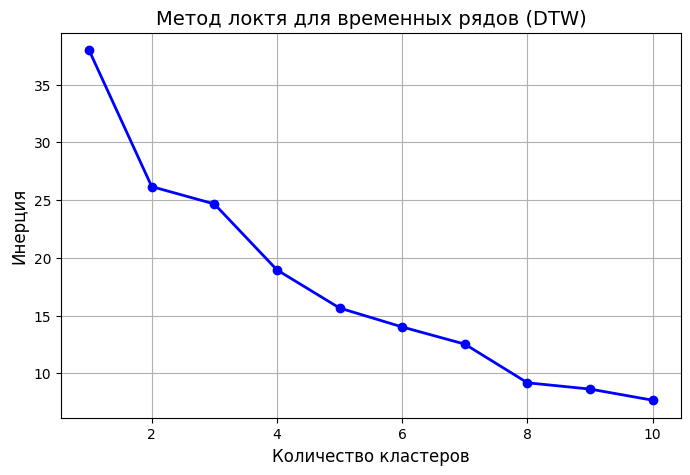

In [3]:
inertia = []  # Для хранения значений инерции
k_values = range(1, 11)  # Количество кластеров для проверки

# Проходим по количествам кластеров
for k in k_values:
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", verbose=False, random_state=42)
    model.fit(time_series_data)
    inertia.append(model.inertia_)  # Добавляем инерцию для текущего k

# Строим график метода локтя
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'bo-', linewidth=2)
plt.title('Метод локтя для временных рядов (DTW)', fontsize=14)
plt.xlabel('Количество кластеров', fontsize=12)
plt.ylabel('Инерция', fontsize=12)
plt.grid()
plt.show()


### Кластеризируем с помощью TKMeans

In [4]:
# Кластеризация
n_clusters = 4
model1 = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=True, random_state=42)
clusters = model1.fit_predict(time_series_data)

# Создаём DataFrame с результатами кластеризации
indicator_clusters = pd.DataFrame({
    "Indicator": indicator_data.index,  # Индикаторы теперь это индексы
    "Cluster": clusters
})

# Выводим распределение индикаторов по кластерам
print(indicator_clusters.groupby("Cluster").size())


40.247 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


18.950 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


18.950 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s



Cluster
0     8
1    19
2     2
3     6
dtype: int64


### Смотрим на корректность разбиения

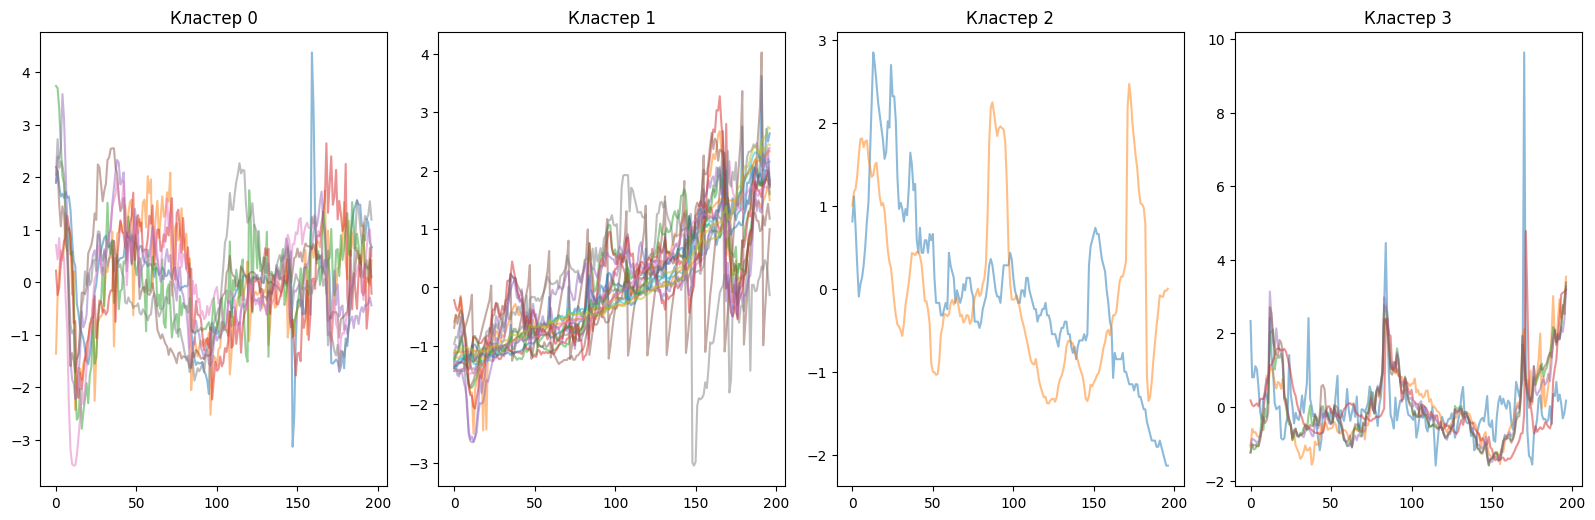

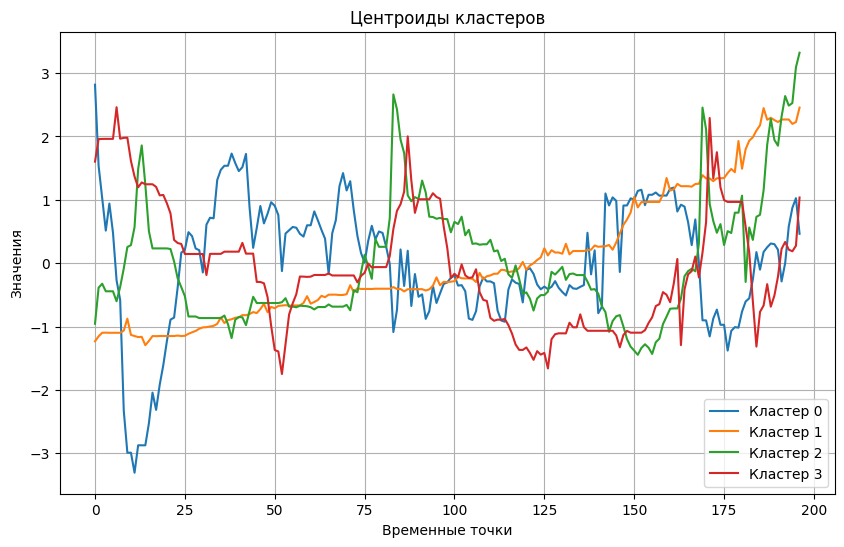

In [5]:
plt.figure(figsize=(20, 10))
for cluster in range(n_clusters):
    plt.subplot(2, 5, cluster + 1)
    for i, series in enumerate(time_series_data):
        if clusters[i] == cluster:
            plt.plot(series.ravel(), alpha=0.5)
    plt.title(f'Кластер {cluster}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for cluster_idx in range(n_clusters):
    plt.plot(model.cluster_centers_[cluster_idx].ravel(), label=f'Кластер {cluster_idx}')
plt.title('Центроиды кластеров')
plt.xlabel('Временные точки')
plt.ylabel('Значения')
plt.legend()
plt.grid()
plt.show()


In [6]:
indicator_clusters

Indicator  Cluster
0          Wagenom        1
1            IMOEX        1
2              USD        1
3              EUR        1
4              CPI        3
5          IMOEX10        1
6            GOV1Y        3
7           GOV10Y        3
8           GOVEXP        1
9    PRODUCERINDEX        1
10           TRADE        0
11          IMPORT        0
12         OILPROD        1
13              М2        1
14              M0        1
15           UNEMP        2
16    CONSTRUCTION        0
17      CBRBALANCE        1
18            INFL        2
19          EXPORT        0
20         DEPOSIT        3
21         GOSDEBT        1
22        INDEXRTS        0
23        OILINDEX        1
24    ELECTROINDEX        0
25    FINANCEINDEX        1
26     POTREBINDEX        1
27      METALINDEX        1
28    TELEKOMINDEX        0
29    PENSIONINDEX        1
30  TRANSPORTINDEX        0
31       CHEMINDEX        1
32              M1        1
33           GOV5Y        3
34          GOV15Y        3

### Добавляем в датасет метки кластеров

In [7]:
df = pd.read_excel('dl_df_deposit.xlsx')
indicator_data = df.set_index("INDICATOR") .iloc[:, :-1]
time_series_data = indicator_data.values 
scaler2 = TimeSeriesScalerMeanVariance()
normalized_data = scaler2.fit_transform(time_series_data)
normalized_df = pd.DataFrame(normalized_data.reshape(normalized_data.shape[0], -1), 
                              index=indicator_data.index, 
                              columns=indicator_data.columns)
normalized_df = normalized_df.reset_index()
result = pd.merge(normalized_df, indicator_clusters, left_on='INDICATOR', right_on='Indicator', how='inner')
result = result.drop(columns=['Indicator',"INDICATOR"])
result = result.set_index(['Cluster'])
result

2008-01-01  2008-02-01  2008-03-01  ...  2024-03-01  2024-04-01  2024-05-01
Cluster                                      ...                                    
1         -1.384936   -1.352152   -1.306153  ...    2.718294    2.500965    2.642048
1         -0.586933   -0.477763   -0.518329  ...    1.642640    1.816750    1.496377
1         -1.383758   -1.404351   -1.430007  ...    1.897128    1.924737    1.782351
1         -1.315495   -1.308573   -1.277646  ...    1.850553    1.838452    1.755083
3          2.335231    0.806811    0.806811  ...   -0.308522   -0.157057    0.173412
1         -1.182272   -0.986086   -1.035005  ...    2.326358    2.383304    1.820171
3         -1.090770   -0.593583   -0.695361  ...    2.615084    2.818995    3.540661
3         -1.228667   -0.995870   -1.151409  ...    2.684879    2.930467    3.280942
1         -1.271820   -1.194002   -1.112391  ...    0.015132    0.556926    0.999855
1         -1.308348   -1.298202   -1.289038  ...    2.212762    2.301129    2.392769
0          1.892086    2.124178    1.840510  ...    1.131337    0.757410    0.667152
0         -1.361766   -0.256870    0.204132  ...    0.069155   -0.047676    0.415773
1         -1.346588   -1.339917   -1.402181  ...    0.414593    0.185550   -0.130217
1         -1.217905   -1.211188   -1.197557  ...    2.600402    2.754369    2.728574
1         -1.268022   -1.262380   -1.265498  ...    2.121284    2.151141    2.154413
2          0.815469    1.117154    0.740048  ...   -2.050540   -2.125962   -2.125962
0          3.741493    3.701976    3.306804  ...    0.000535    0.343017    0.672327
1         -1.355908   -1.336780   -1.339800  ...    2.012386    1.994729    1.842715
2          1.009092    1.173953    1.205941  ...   -0.019448   -0.019448    0.005159
0          0.221152   -0.243399   -0.097445  ...   -0.518864    0.651746   -0.219331
3          0.178968    0.058788    0.018729  ...    3.107346    3.131382    3.187466
1         -1.119444   -1.114688   -1.104728  ...    2.277415    2.329491    2.333426
0          1.917799    2.391826    2.361598  ...   -0.407672   -0.293612   -0.441585
1         -1.226787   -1.140289   -1.112946  ...    1.851894    1.981138    1.596881
0          2.196811    2.132643    1.482857  ...    0.248882    0.434131    0.098517
1         -0.216864   -0.335944   -0.400068  ...    1.937884    2.004953    1.768916
1         -1.431866   -1.395217   -1.501501  ...    2.027137    2.203776    1.716715
1         -0.692070   -0.466945   -0.623861  ...    1.257421    1.434486    1.177687
0          0.709766    0.435682    0.841674  ...    0.950329    1.005418    0.496285
1         -1.429081   -1.429935   -1.424265  ...    1.709126    1.730558    1.640775
0          2.049384    2.728101    2.177805  ...    1.284109    1.543096    1.191663
1         -0.967695   -0.845165   -0.861157  ...    2.061612    2.051006    1.719608
1         -1.081641   -1.085566   -1.073602  ...    2.391696    2.456257    2.445326
3         -1.033605   -0.863505   -0.885653  ...    2.041932    2.387448    3.211371
3         -1.241268   -1.026799   -1.037731  ...    2.768048    2.525990    3.384906

[35 rows x 197 columns]

### Проходимся PCA по каждому кластеру в каждый момент времени

In [8]:
# Получаем уникальные кластеры и месяцы
clusters = result.index.get_level_values(0).unique()  
months = result.columns 
pca_results = []

for cluster in clusters:
    cluster_data = result.loc[cluster] 
    
    for month in months:
        month_data = cluster_data[month].dropna().values.reshape(-1, 1)  # Извлекаем данные за месяц и удаляем пропуски
        if month_data.size > 0:
            pca = PCA(n_components=1) 
            pca_result = pca.fit_transform(month_data)  
            pca_results.append({
                'Cluster': cluster,
                'Month': month,
                'PCA_Result': pca_result.flatten()[0]
            })

results_df = pd.DataFrame(pca_results)
print(results_df)

     Cluster      Month  PCA_Result
0          1 2008-01-01   -0.238228
1          1 2008-02-01   -0.247671
2          1 2008-03-01   -0.186378
3          1 2008-04-01   -0.197730
4          1 2008-05-01   -0.286743
..       ...        ...         ...
783        2 2024-01-01    0.905676
784        2 2024-02-01   -0.940926
785        2 2024-03-01   -1.015546
786        2 2024-04-01   -1.053257
787        2 2024-05-01    1.065560

[788 rows x 3 columns]


In [9]:
pivot_df = results_df.pivot(index='Month', columns='Cluster', values='PCA_Result')
pivot_df

Cluster            0         1         2         3
Month                                             
2008-01-01 -0.471245 -0.238228  0.096811  2.681916
2008-02-01  0.497411 -0.247671  0.028400  1.242504
2008-03-01  0.325768 -0.186378  0.232947  1.297580
2008-04-01  0.196572 -0.197730  0.539181  1.542129
2008-05-01  0.122671 -0.286743  0.850765  1.468076
...              ...       ...       ...       ...
2024-01-01  0.466552 -0.323111  0.905676  1.533108
2024-02-01 -0.890885 -0.432019 -0.940926  1.924699
2024-03-01  0.786611 -0.859045 -1.015546  2.459983
2024-04-01  0.208219 -0.574664 -1.053257  2.429928
2024-05-01  0.307052 -0.858707  1.065560  2.623047

[197 rows x 4 columns]

### Строим модель

In [10]:
import pickle
# Для воспроизводимости графика
random.seed(42)
np.random.seed(42)

pivot_df = results_df.pivot(index='Month', columns='Cluster', values='PCA_Result')
X = pivot_df.values
model = hmm.GaussianHMM(n_components=4, covariance_type="full", init_params="mc", n_iter=1000, tol=0.001, random_state=42) 
model.startprob_ = np.array([0, 1, 0, 0]) 

#Предполагаем, что вероятность перейти в другое состояние маленькая
# Начальные значения для p_00, p_11, p_22 и p_33
p_00 = 0.9   # Вероятность остаться в состоянии 0
p_11 = 0.9   # Вероятность остаться в состоянии 1
p_22 = 0.9   # Вероятность остаться в состоянии 2
p_33 = 0.9   # Вероятность остаться в состоянии 3

# Матрица переходов, с учетом, что из пика нельзя попасть сразу в рецессию итд
model.transmat_ = np.array([
    [p_00, (1 - p_00), 0, 0],          # Переходы из состояния 0
    [0, p_11, (1 - p_11), 0],          # Переходы из состояния 1
    [0, 0, p_22, (1 - p_22)],          # Переходы из состояния 2
    [(1 - p_33), 0, 0, p_33]           # Переходы из состояния 3
])

#Сохраняем начальные параметры
initial_params = {
    'startprob_': model.startprob_,
    'transmat_': model.transmat_
}

with open('initial_params.pkl', 'wb') as f:
    pickle.dump(initial_params, f)

model.fit(X)
hidden_states = model.predict(X)

#Сохраняем окалиброванные параметры
trained_params = {
    'startprob_': model.startprob_,
    'transmat_': model.transmat_,
    'means_': model.means_,
    'covars_': model.covars_
}

with open('trained_params.pkl', 'wb') as f:
    pickle.dump(trained_params, f)

# Вывод параметров параметров
print("Начальные вероятности:")
print(model.startprob_)
print("Откалиброванная матрица переходов:")
print(model.transmat_)
print("Откалиброванные средние значения:")
print(model.means_)
print("Откалиброванные ковариационные матрицы:")
print(model.covars_)

print("Обученная матрица переходов:")
print(model.transmat_)
print("Изменения лосса на каждом шаге:")
model.monitor_

Начальные вероятности:
[0. 1. 0. 0.]
Откалиброванная матрица переходов:
[[0.84170589 0.15829411 0.         0.        ]
 [0.         0.91219985 0.08780015 0.        ]
 [0.         0.         0.9592728  0.0407272 ]
 [0.09023473 0.         0.         0.90976527]]
Откалиброванные средние значения:
[[ 0.99360722  0.03343993  0.30710762  0.64643837]
 [-0.03467904 -0.14212718  0.26751904  0.65602131]
 [-0.06588184 -0.02085948  0.14259795  0.1281355 ]
 [-0.59365546 -0.14176866  0.08782419  0.91726472]]
Откалиброванные ковариационные матрицы:
[[[ 1.00018077e+00 -4.38011410e-02 -2.07593285e-01 -4.09186341e-02]
  [-4.38011410e-02  6.96933778e-02 -3.48437692e-02  1.02135260e-02]
  [-2.07593285e-01 -3.48437692e-02  3.40268945e-01 -5.29238924e-02]
  [-4.09186341e-02  1.02135260e-02 -5.29238924e-02  3.55489960e-01]]

 [[ 2.12339976e-01 -1.91977366e-02 -2.30015346e-03 -1.27287007e-02]
  [-1.91977366e-02  1.90487603e-02 -7.44534631e-04  4.90553094e-03]
  [-2.30015346e-03 -7.44534631e-04  4.73305904e-01

ConvergenceMonitor(
    history=[-688.3169590327892, -557.5129118010492, -490.6782139752076, -452.11807078849546, -448.76138846431934, -447.20394872447065, -445.7962694406335, -443.9239709679658, -442.3897558025013, -442.03819027079714, -441.99408522059736, -441.9886662078438, -441.98772295550384],
    iter=13,
    n_iter=1000,
    tol=0.001,
    verbose=False,
)

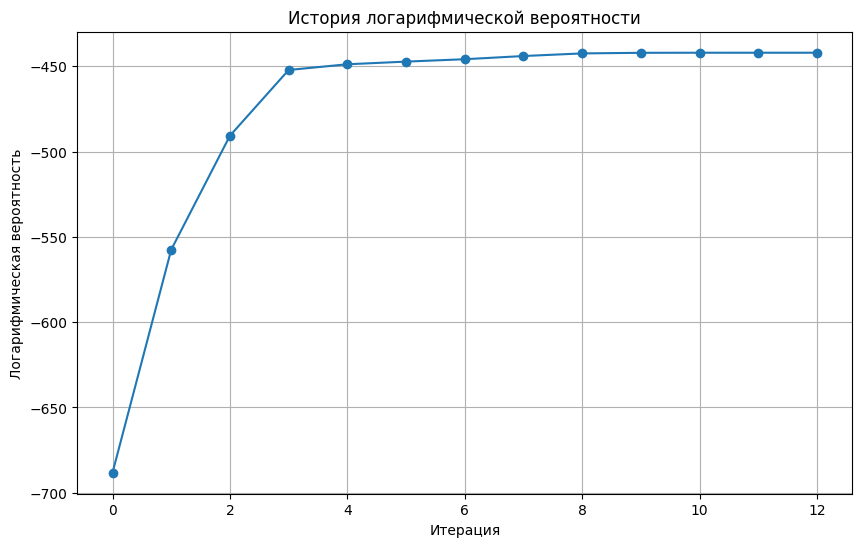

In [11]:
history = list(model.monitor_.history)  
plt.figure(figsize=(10, 6))
plt.plot(history, marker='o')
plt.title('История логарифмической вероятности')
plt.xlabel('Итерация')
plt.ylabel('Логарифмическая вероятность')
plt.grid()
plt.show()

In [12]:
log_likelihood = model.score(X)
print(f"Логарифмическая вероятность наблюдаемых данных: {log_likelihood}")

Логарифмическая вероятность наблюдаемых данных: -441.98748377596195


In [13]:
pivot_df['Hidden_States'] = hidden_states
pivot_df['Hidden_States'] = pivot_df['Hidden_States'].replace({0:0.1, 1:1, 2: -0.1, 3:-1}) #меняем значения для красивого графика
pivot_df = pivot_df.reset_index()
pivot_df['Hidden_States_Label'] = pivot_df['Hidden_States'].replace({0.1: 'рост', 1: 'пик', -0.1: 'спад', -1: 'кризис'})
pivot_df = pivot_df.reset_index()

### Результат моделирования

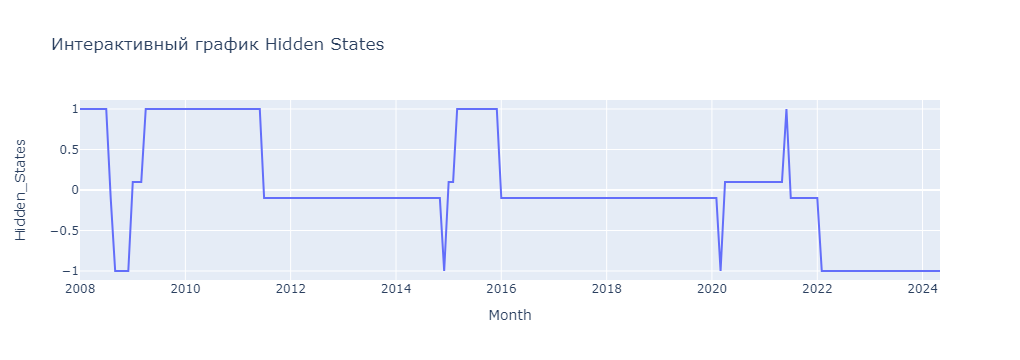

In [14]:
fig = px.line(pivot_df, x='Month', y='Hidden_States', title='Интерактивный график Hidden States', hover_data={'Hidden_States_Label': True})
fig.show()

### Дополнительный график

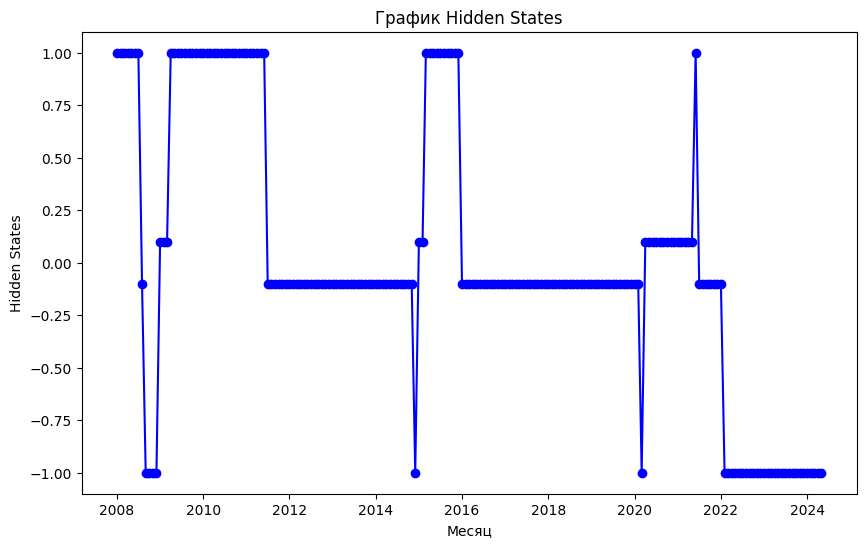

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df['Month'], pivot_df['Hidden_States'], marker='o', linestyle='-', color='b')
plt.title('График Hidden States')
plt.xlabel('Месяц')
plt.ylabel('Hidden States')
plt.show()

### Предсказываем на t+1

/tmp/ipykernel_2858/2473445474.py:36: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Cluster  index      Month  ...  Hidden_States  Hidden_States_Label
197        197 2024-06-01  ...           -1.0               кризис

[1 rows x 8 columns]

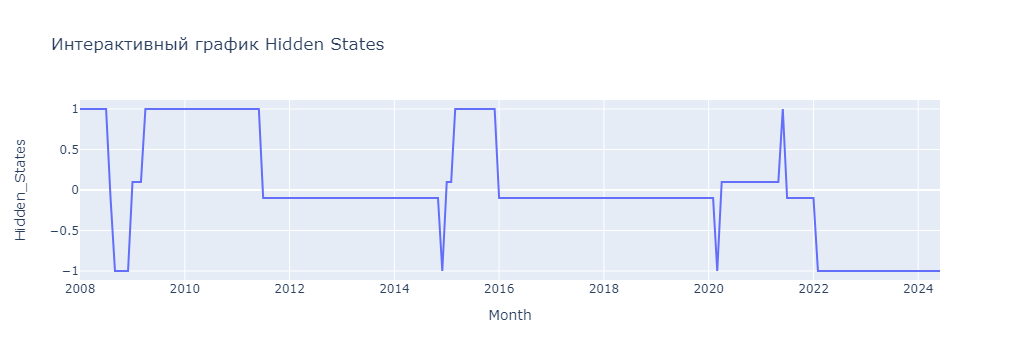

In [16]:
from sklearn.preprocessing import StandardScaler
df = pd.read_excel('dl_df_deposit.xlsx')
indicator_data = df.set_index("INDICATOR").iloc[:, -1:]
time_series_data = indicator_data.values 
scaler = StandardScaler()
normalized_data = scaler.fit_transform(time_series_data)
normalized_df = pd.DataFrame(normalized_data.reshape(normalized_data.shape[0], -1), 
                              index=indicator_data.index, 
                              columns=indicator_data.columns)
normalized_df = normalized_df.reset_index()
result = pd.merge(normalized_df, indicator_clusters, left_on='INDICATOR', right_on='Indicator', how='inner')
result = result.drop(columns=['Indicator',"INDICATOR"])
result = result.set_index(['Cluster'])
clusters = result.index.get_level_values(0).unique()  
months = result.columns 
pca_results = []

for cluster in clusters:
    cluster_data = result.loc[cluster] 
    
    for month in months:
        month_data = cluster_data[month].dropna().values.reshape(-1, 1) 
        if month_data.size > 0:
            pca = PCA(n_components=1) 
            pca_result = pca.fit_transform(month_data)  
            pca_results.append({
                'Cluster': cluster,
                'Month': month,
                'PCA_Result': pca_result.flatten()[0]
            })

results_df1 = pd.DataFrame(pca_results)
results_df1 = results_df1.reset_index()
results_df1 = results_df1.pivot(index='Month', columns='Cluster', values='PCA_Result')
pivot_df = results_df.pivot(index='Month', columns='Cluster', values='PCA_Result')
pivot_df1 = pivot_df.append(results_df1)
X1 = pivot_df1.values
hidden_states1 = model.predict(X1)
pivot_df1['Hidden_States'] = hidden_states1
pivot_df1['Hidden_States'] = pivot_df1['Hidden_States'].replace({0:0.1, 1:1, 2: -0.1, 3:-1})
pivot_df1 = pivot_df1.reset_index()
pivot_df1['Hidden_States_Label'] = pivot_df1['Hidden_States'].replace({0.1: 'рост', 1: 'пик', -0.1: 'спад', -1: 'кризис'})
pivot_df1 = pivot_df1.reset_index()
display(pivot_df1.tail(1))
fig = px.line(pivot_df1, x='Month', y='Hidden_States', title='Интерактивный график Hidden States', hover_data={'Hidden_States_Label': True})
fig.show()

### Дополнительный код, для запуска модели с сохраненными весами 

In [17]:
import pickle
from hmmlearn import hmm

with open('trained_params.pkl', 'rb') as f:
    loaded_params = pickle.load(f)

model = hmm.GaussianHMM(n_components=4, covariance_type="full", init_params="mc", n_iter=1000, tol=0.001, random_state=42)

# Установка обученных параметров
model.startprob_ = loaded_params['startprob_']
model.transmat_ = loaded_params['transmat_']
model.means_ = loaded_params['means_']
model.covars_ = loaded_params['covars_']

hidden_states = model.predict(X)

In [18]:
pivot_df = results_df.pivot(index='Month', columns='Cluster', values='PCA_Result')
pivot_df['Hidden_States'] = hidden_states
pivot_df['Hidden_States'] = pivot_df['Hidden_States'].replace({0:0.1, 1:1, 2: -0.1, 3:-1}) #меняем значения для красивого графика
pivot_df = pivot_df.reset_index()
pivot_df['Hidden_States_Label'] = pivot_df['Hidden_States'].replace({0.1: 'рост', 1: 'пик', -0.1: 'спад', -1: 'кризис'})
pivot_df = pivot_df.reset_index()

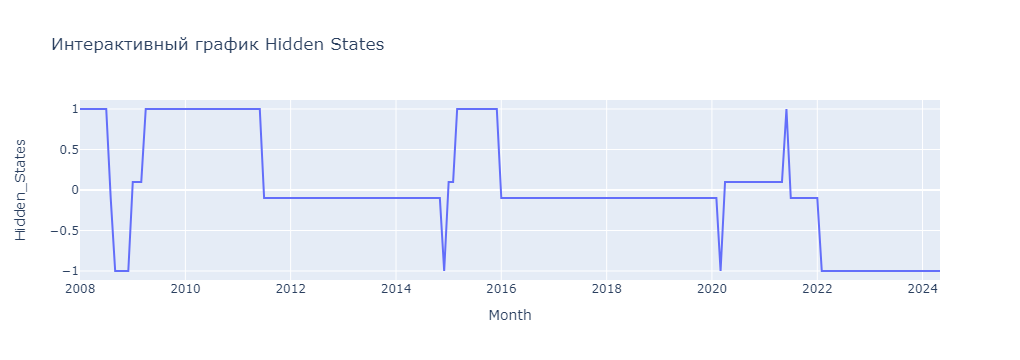

In [19]:
fig = px.line(pivot_df, x='Month', y='Hidden_States', title='Интерактивный график Hidden States', hover_data={'Hidden_States_Label': True})
fig.show()

### Дополнительный график

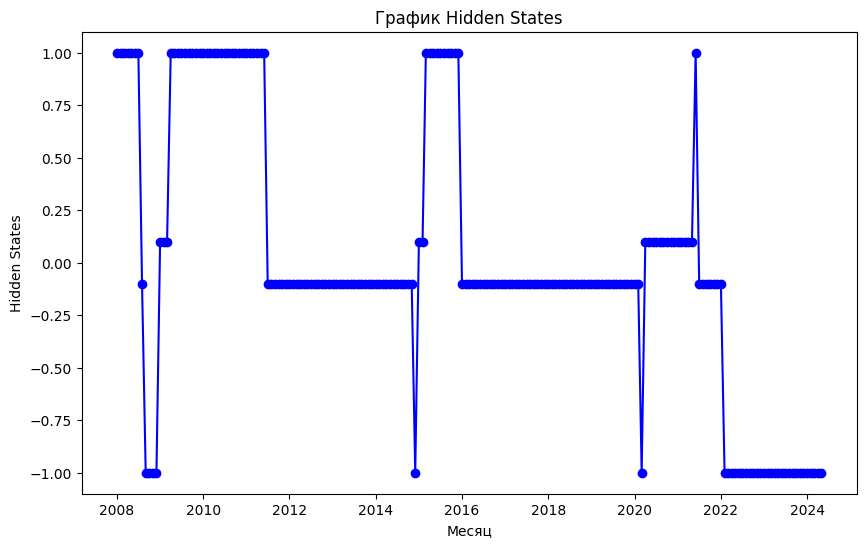

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df['Month'], pivot_df['Hidden_States'], marker='o', linestyle='-', color='b')
plt.title('График Hidden States')
plt.xlabel('Месяц')
plt.ylabel('Hidden States')
plt.show()